<a href="https://colab.research.google.com/github/sripraks/CNN/blob/main/train_models_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib
matplotlib.use("Agg")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

In [ ]:
class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [ ]:
# load the training and testing data, then scale it into the
# range [0, 1]
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [ ]:
# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck"]

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,height_shift_range=0.1, horizontal_flip=True,fill_mode="nearest")

[INFO] training model 1/5
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
781/781 [==============================] - 15s 20ms/step - loss: 2.2668 - accuracy: 0.3236 - val_loss: 1.6981 - val_accuracy: 0.4120
Epoch 2/5
781/781 [==============================] - 15s 19ms/step - loss: 1.7557 - accuracy: 0.4186 - val_loss: 1.3542 - val_accuracy: 0.5288
Epoch 3/5
781/781 [==============================] - 15s 19ms/step - loss: 1.5049 - accuracy: 0.4786 - val_loss: 1.2248 - val_accuracy: 0.5699
Epoch 4/5
781/781 [==============================] - 15s 19ms/step - loss: 1.3295 - accuracy: 0.5340 - val_loss: 1.2702 - val_accuracy: 0.5581
Epoch 5/5
781/781 [==============================] - 15s 19ms/step - loss: 1.2326 - accuracy: 0.5689 - val_loss: 1.0021 - val_accuracy: 0.6471
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in Ten

ValueError: ignored

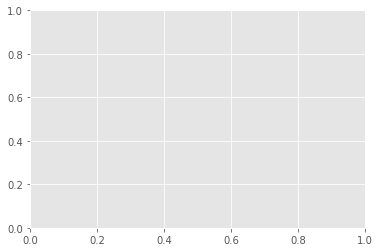

In [ ]:
# loop over the number of models to train
for i in np.arange(0, 5):
	# initialize the optimizer and model
	print("[INFO] training model {}/{}".format(i + 1,5))
	opt = SGD(lr=0.01, decay=0.01 / 40, momentum=0.9,nesterov=True)
	model = MiniVGGNet.build(width=32, height=32, depth=3,classes=10)
	model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

	# train the network
	H = model.fit_generator(aug.flow(trainX, trainY, batch_size=32),validation_data=(testX, testY), epochs=5,
		steps_per_epoch=len(trainX) // 64, verbose=1)

	# save the model to disk
	p = ["models", "model_{}.model".format(i)]
	model.save(os.path.sep.join(p))

	# evaluate the network
	predictions = model.predict(testX, batch_size=64)
	report = classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=labelNames)

	# save the classification report to file
	p = ["models", "model_{}.txt".format(i)]
	f = open(os.path.sep.join(p), "w")
	f.write(report)
	f.close()

	# plot the training loss and accuracy
	p = ["output", "model_{}.png".format(i)]
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, 40), H.history["loss"],
		label="train_loss")
	plt.plot(np.arange(0, 40), H.history["val_loss"],
		label="val_loss")
	plt.plot(np.arange(0, 40), H.history["accuracy"],
		label="train_acc")
	plt.plot(np.arange(0, 40), H.history["val_accuracy"],
		label="val_acc")
	plt.title("Training Loss and Accuracy for model {}".format(i))
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend()
	plt.savefig(os.path.sep.join(p))
	plt.close()

# New Section